In [6]:
config_file = "/users/kcochran/projects/new_procap_models/modisco_out/procap/"
config_file += "K562/strand_merged_umap/2022-10-05_03-39-32_profile_in/config.json"

In [7]:
# need to specify for every expt

patterns_to_keep = [0,1,2,3,4,5,7,8,9,10,13,14,15]

# This is specific to K562

motif_keys_to_labels = ["BRE/SP", "CA-Inr", "GABPA/ELK4", "NFY", "NRF1", "ATF1",
                        "YY1", "TA-Inr", "TATA", "THAP11",
                        "AP1",  "CTCF", "ZBTB33"]

In [166]:
import os
import numpy as np
import sys
sys.path.append("../2_train_models")
sys.path.append("../5_modisco")
from utils import load_json
#from motif_hits_utils import import_motif_hits, filter_peak_hits_by_fdr
from data_loading import extract_peaks
from modiscolite_utils import load_scores
#import gzip
from file_configs import ValFilesConfig, TrainFilesConfig
#import pandas as pd
import matplotlib.pyplot as plt
#import matplotlib.patches as patches
from collections import defaultdict

%matplotlib inline

In [10]:
config = load_json(config_file)

proj_dir = config["proj_dir"]

cell_type = config["cell_type"]
model_type = config["model_type"]
timestamp = config["timestamp"]
data_type = config["data_type"]

genome_path = config["genome_path"]
chrom_sizes = config["chrom_sizes"]

in_window = config["in_window"]
out_window = config["out_window"]

slice_len = config["slice"]

peak_path = config["train_val_peak_path"]

modisco_results_path = config["results_save_path"]

scores_path = config["scores_path"]

# need filepaths from these
train_config = TrainFilesConfig(cell_type, model_type, timestamp, data_type)
val_config = ValFilesConfig(cell_type, model_type, timestamp, data_type)

val_peak_path = val_config.val_peak_path

Timestamp: 2022-10-05_03-39-32
Timestamp: 2022-10-05_03-39-32


In [11]:
from motif_hits_utils import load_coords

coords = load_coords(peak_path, in_window=in_window)
val_coords = load_coords(val_peak_path, in_window=in_window)

In [12]:
from load_annotations_utils import get_annotations_for_peaks, get_ccre_bed

ccre_annots = get_annotations_for_peaks(coords, get_ccre_bed(cell_type), in_window, out_window)
val_ccre_annots = get_annotations_for_peaks(val_coords, get_ccre_bed(cell_type), in_window, out_window)

In [98]:
onehot_seqs, true_profs = extract_peaks(genome_path,
                                        chrom_sizes,
                                        train_config.plus_bw_path,
                                        train_config.minus_bw_path,
                                        peak_path,
                                        in_window=in_window,
                                        out_window=out_window,
                                        max_jitter=0,
                                        verbose=True)

scores = load_scores(scores_path,
                     slice_len=slice_len,
                     in_window=in_window)

true_counts = true_profs.sum(axis=(1,2))  # strand-merged

pred_profs = np.exp(np.load(val_config.pred_profiles_train_val_path))
pred_counts = np.exp(np.load(val_config.pred_logcounts_train_val_path))

Loading genome sequence from /mnt/lab_data2/kcochran/new_procap_models/genomes/hg38.withrDNA.fasta


Reading FASTA: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:35<00:00,  1.48s/it]
Loading Peaks: 27000it [00:40, 665.77it/s]


== In Extract Peaks ==
Peak filepath: /mnt/lab_data2/kcochran/new_procap_models/deepshap_out/procap/K562/strand_merged_umap/2022-10-05_03-39-32_in/peaks_uni_and_bi_train_and_val.bed.gz
Sequence length (with jitter): 2114
Profile length (with jitter): 1000
Max jitter applied: 0
Num. Examples: 27000
Mask loaded? False


In [14]:
val_profs = load_observed_profiles(val_config.plus_bw_path,
                                   val_config.minus_bw_path,
                                   val_config.val_peak_path,
                                   slice_len=slice_len,
                                   out_window=out_window)

val_counts = val_profs.sum(axis=(1,2))  # strand-merged

val_pred_counts = np.exp(np.load(val_config.pred_logcounts_val_path))

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/new_procap_models/models/procap/K562/strand_merged_umap/2022-10-05_03-39-32_in/peaks_uni_and_bi_val.bed.gz
Profile length: 1000
Num. Examples: 3834


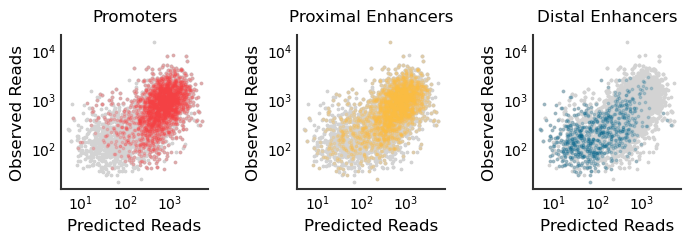

In [15]:
def plot_true_pred_counts_by_annot(true_counts, pred_counts, overlap_annots_bools):
    
    annots_to_labels = {"PLS" : "Promoters",
                        "pELS" : "Proximal Enhancers",
                        "dELS" : "Distal Enhancers"}
    
    annots_to_colors = {"PLS" : "#f94144",
                        "pELS" : "#ffbc42",
                        "dELS" : "#05668d"}
    
    fig, axes = plt.subplots(1,3,figsize=(8,2))
    
    for ax, sup_annot_name in zip(axes, ["PLS", "pELS", "dELS"]):
        other_x = []
        other_y = []
        for annot_name in ["PLS", "pELS", "dELS"]:
            #if not sup_annot_name == annot_name:
            other_x.extend(pred_counts[overlap_annots_bools[annot_name]])
            other_y.extend(true_counts[overlap_annots_bools[annot_name]])

        ax.scatter(other_x, other_y, alpha = 1, s = 3,
                    label = "Other", color = "lightgray")
        
        # have to plot last
        true_counts_subset = true_counts[overlap_annots_bools[sup_annot_name]]
        pred_counts_subset = pred_counts[overlap_annots_bools[sup_annot_name]]

        ax.scatter(pred_counts_subset, true_counts_subset, alpha = 0.2, s = 3,
                    label = annots_to_labels[sup_annot_name],
                    color = annots_to_colors[sup_annot_name])

        ax.semilogy()
        ax.semilogx()

        ax.set_xlabel("Predicted Reads", fontsize = 12)
        ax.set_ylabel("Observed Reads", fontsize = 12)


        ax.spines["left"].set_linewidth(1.5)
        ax.spines["bottom"].set_linewidth(1.5)
        ax.spines["left"].set_color("#333333")
        ax.spines["bottom"].set_color("#333333")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.xaxis.set_ticks_position('none') 
        ax.yaxis.set_ticks_position('none')
        ax.tick_params(axis='both', labelsize=10, length=0)
        
        ax.set_title(annots_to_labels[sup_annot_name], fontsize=12, pad=10)

    plt.subplots_adjust(wspace=0.6)
    plt.show()

    
plot_true_pred_counts_by_annot(val_counts, val_pred_counts, val_ccre_annots)

In [99]:
from BPNet_strand_merged_umap import Model
import torch

# re-define the model's forward func so that it returns output of intermediate layer

class BPNet_Embeddings_Loader(Model):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, X):
        start, end = self.trimming, X.shape[2] - self.trimming

        X = self.relus[0](self.iconv(X))

        for i in range(self.n_layers):
            X_conv = self.relus[i+1](self.rconvs[i](X))
            X = torch.add(X, X_conv)
            
        X = X[:, :, start - self.deconv_kernel_size//2 : end + self.deconv_kernel_size//2]

        # return result of global avg pooling
        # (beginning of counts head, before linear layer)
        X = torch.mean(X, axis=2)
        return X

    
# the arch-related args here have to match what was input when the model was trained
params = load_json(train_config.params_path)

embedder = BPNet_Embeddings_Loader("_",
                                   n_filters=params["n_filters"],
                                   n_layers=params["n_layers"],
                                   trimming=params["trimming"],
                                   alpha=params["counts_weight"])

loaded_model_state = torch.load(train_config.model_save_path).state_dict()
embedder.load_state_dict(loaded_model_state)

<All keys matched successfully>

In [100]:
embedder

BPNet_Embeddings_Loader(
  (iconv): Conv1d(4, 512, kernel_size=(21,), stride=(1,), padding=(10,))
  (rconvs): ModuleList(
    (0): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
    (1): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
    (2): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
    (3): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
    (4): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
    (5): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
    (6): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
    (7): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(256,), dilation=(256,))
  )
  (fconv): Conv1d(512, 2, kernel_size=(75,), stride=(1,))
  (relus): ModuleList(
    (0): ReLU()
    (1): ReLU()
    (2): ReLU()
    (3): ReLU()
    (4): ReLU()
    (5): Re

In [101]:
os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-40f43250-998e-586a-ac37-d6520e92590f"

embedder.eval()
embedder = embedder.cuda()

In [102]:
def get_embeddings(embedder, seqs, batch_size=128):
    if not seqs.shape[-2] == 4:
        seqs = np.swapaxes(seqs, -2, -1)
    seqs = torch.tensor(seqs, dtype=torch.float)
    embedder = embedder.cuda()
    with torch.no_grad():
        starts = np.arange(0, seqs.shape[0], batch_size)
        ends = starts + batch_size

        embeds = []
        for i, (start, end) in enumerate(zip(starts, ends)):
            if i % 10 == 0:
                print("Batch " + str(i) + " of " + str(len(starts)))
            
            seqs_batch = seqs[start:end]
            embeds_batch = embedder(seqs_batch.cuda()).cpu().detach().numpy()
            embeds.append(embeds_batch)

    embedder = embedder.cpu()
    return np.concatenate(embeds)

peak_embeds = get_embeddings(embedder, onehot_seqs)

Batch 0 of 211
Batch 10 of 211
Batch 20 of 211
Batch 30 of 211
Batch 40 of 211
Batch 50 of 211
Batch 60 of 211
Batch 70 of 211
Batch 80 of 211
Batch 90 of 211
Batch 100 of 211
Batch 110 of 211
Batch 120 of 211
Batch 130 of 211
Batch 140 of 211
Batch 150 of 211
Batch 160 of 211
Batch 170 of 211
Batch 180 of 211
Batch 190 of 211
Batch 200 of 211
Batch 210 of 211


In [107]:
promoter_embeds = peak_embeds[ccre_annots["PLS"]]
p_enhancer_embeds = peak_embeds[ccre_annots["pELS"]]
d_enhancer_embeds = peak_embeds[ccre_annots["dELS"]]

print(len(promoter_embeds), len(p_enhancer_embeds), len(d_enhancer_embeds))

14829 15321 5097


In [108]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
pcs = pca.fit(peak_embeds)
promoter_pcs = pca.transform(promoter_embeds)
d_enhancer_pcs = pca.transform(d_enhancer_embeds)
p_enhancer_pcs = pca.transform(p_enhancer_embeds)

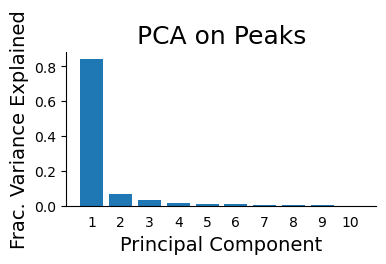

In [112]:
plt.figure(figsize=(4,2))
plt.bar(range(1, 10+1), pca.explained_variance_ratio_)
plt.xlabel("Principal Component", fontsize = 14)
plt.ylabel("Frac. Variance Explained", fontsize = 14)
plt.title("PCA on Peaks", fontsize = 18)

plt.xticks(range(1, 10+1))
for side in ["right", "top"]:
    plt.gca().spines[side].set_visible(False)
plt.gca().xaxis.set_ticks_position('none') 

plt.show()

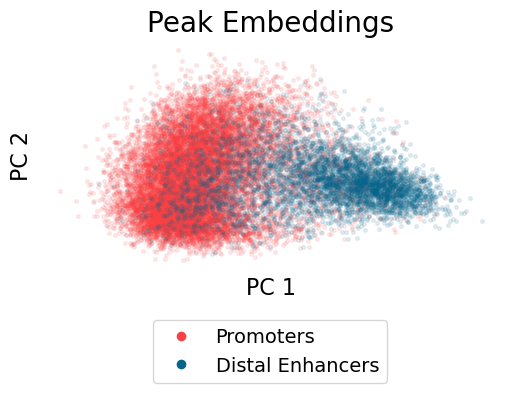

In [130]:
from matplotlib.lines import Line2D

def plot_embeds_pca(promoter_pcs, d_enhancer_pcs, p_enhancer_pcs):
    plt.figure(figsize=(6,3))

    plt.scatter(promoter_pcs[..., 0], promoter_pcs[..., 1],
                alpha = 0.1, s = 7, c="#f94144")
    plt.scatter(d_enhancer_pcs[..., 0], d_enhancer_pcs[..., 1],
                alpha = 0.1, s = 7, c="#05668d")
    #plt.scatter(p_enhancer_pcs[..., 0], p_enhancer_pcs[..., 1], alpha = 0.05, s = 5)

    plt.xlabel("PC 1", fontsize = 16)
    plt.ylabel("PC 2", fontsize = 16)
    plt.title("Peak Embeddings", fontsize = 20)

    for side in ["right", "top", "bottom", "left"]:
        plt.gca().spines[side].set_visible(False)
    plt.xticks([])
    plt.yticks([])
    plt.tick_params("both", length=0)


    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Promoters',
                              markerfacecolor="#f94144", markersize=8),
                       Line2D([0], [0], marker='o', color='w', label='Distal Enhancers',
                              markerfacecolor="#05668d", markersize=8)]

    plt.legend(handles=legend_elements, fontsize = 14, bbox_to_anchor = (0.2,-0.02,0.57,-0.15))

    plt.show()
    
plot_embeds_pca(promoter_pcs, d_enhancer_pcs, p_enhancer_pcs)

In [16]:
### Load Motifs

from motif_hits_utils import import_motif_hits, filter_peak_hits_by_fdr, make_peak_table, get_peak_hits_with_fix, get_peak_motif_counts

# this function differs slightly from Fig1.ipynb; to-do: standardize input for this

def load_motif_hits(modisco_results_path, train_val_peak_path, in_window, fdr_cutoff=0.05):
    modisco_hits_path = os.path.join(os.path.dirname(modisco_results_path), "motif_hits.bed")
    
    hits = import_motif_hits(modisco_hits_path)
    motif_keys = list(set(hits["key"]))

    # Filter motif hit table by p-value using FDR estimation
    filtered_hits = filter_peak_hits_by_fdr(hits, fdr_cutoff=fdr_cutoff)

    train_val_peak_table = make_peak_table(train_val_peak_path, in_window)

    # Match peaks to motif hits
    peak_hits = get_peak_hits_with_fix(train_val_peak_table, filtered_hits)

    # Count hits of each motif in each peak
    peak_hit_counts = get_peak_motif_counts(peak_hits, motif_keys)
    
    return filtered_hits, peak_hits, peak_hit_counts


motif_hits, motif_hits_peaks, motif_hit_counts = load_motif_hits(modisco_results_path, peak_path, in_window)

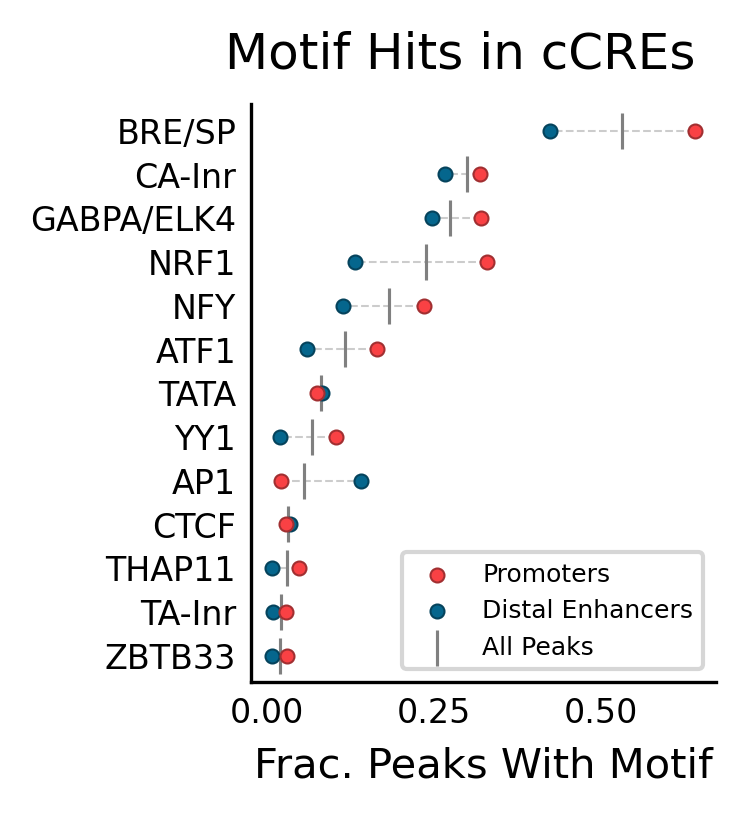

In [221]:
from collections import defaultdict

def plot_motif_enrichment_in_cCREs_condensed(peak_hit_counts, overlap_annots_bools,
                                        annots_to_plot = ["PLS", "dELS"],
                                        motif_keys_to_labels = motif_keys_to_labels):
    
    annots_to_labels = {"PLS" : "Promoters",
                        "pELS" : "Proximal Enhancers",
                        "dELS" : "Distal Enhancers"}
    
    annots_to_colors = {"All Peaks" : "gray", "PLS" : "#f94144", "dELS" : "#05668d"}
    annots_to_edgecolors = {"All Peaks" : "gray", "PLS" : "#A12F31", "dELS" : "#05435C"}
    annots_to_sizes = {"All Peaks" : 75, "PLS" : 45, "dELS" : 45}
    
    annot_vals = defaultdict(lambda : [])
    
    motif_keys = range(len(motif_keys_to_labels))
    for motif_index in motif_keys:
        total_peaks_with_motif = np.sum(peak_hit_counts[:, motif_index] > 0)

        for key in annots_to_plot:
            overlap_peaks = np.sum(overlap_annots_bools[key])
            overlap_peaks_with_motif = np.sum(peak_hit_counts[overlap_annots_bools[key], motif_index] > 0)

            annot_vals[key].append(overlap_peaks_with_motif / overlap_peaks)
            
        annot_vals["All Peaks"].append(total_peaks_with_motif / peak_hit_counts.shape[0])

    plot_order = np.argsort(annot_vals["All Peaks"])[::-1]
        
    plt.figure(figsize=(2,2.5), dpi=300)
    
    add_to_legend = True
    for y, plot_i in enumerate(plot_order):
        plt.plot([annot_vals["PLS"][plot_i], annot_vals["dELS"][plot_i]],
                 [len(motif_keys) - y - 1] * 2,
                 color="gray", alpha = 0.4, linewidth=0.5, linestyle="dashed")
        
        for i, (key, vals) in enumerate(annot_vals.items()):
            if key == "All Peaks":
                plt.scatter(vals[plot_i], len(motif_keys) - y - 1,
                            label=key if add_to_legend else "",
                            color=annots_to_colors[key],
                            linewidth=0.75,
                            s=annots_to_sizes[key],
                            zorder=10 - i, marker="|")
            else:
                plt.scatter(vals[plot_i], len(motif_keys) - y - 1,
                            label=annots_to_labels[key] if add_to_legend else "",
                            color=annots_to_colors[key],
                            edgecolor=annots_to_edgecolors[key],
                            linewidth=0.5,
                            s=annots_to_sizes[key],
                            zorder=10 - i, marker=".")
            
        add_to_legend = False

    plt.legend(fontsize=6, loc="lower right")#, bbox_to_anchor=(0.1, 0, 1, 1))
    plt.yticks(motif_keys[::-1], np.array(motif_keys_to_labels)[plot_order], fontsize=10)
    plt.tick_params(left=False, length=0)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.xlabel("Frac. Peaks With Motif", fontsize=10)
    plt.title("Motif Hits in cCREs", fontsize=12, y=1.02, x=0.45)

    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.show()
    
plot_motif_enrichment_in_cCREs_condensed(motif_hit_counts, ccre_annots)

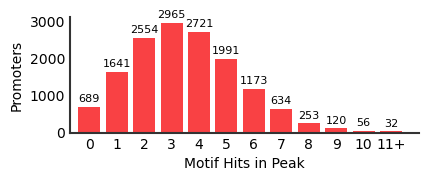

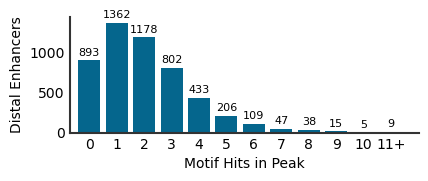

In [167]:
def plot_motif_complexity_across_ccres(motif_hit_counts, ccre_annots):
    annots_to_colors = {"All Peaks" : "gray", "PLS" : "#f94144", "dELS" : "#05668d"}

    annots_to_labels = {"PLS" : "Promoters",
                        "pELS" : "Proximal Enhancers",
                        "dELS" : "Distal Enhancers"}
    
    for key in ["PLS", "dELS"]:
        motif_hit_counts_annot = motif_hit_counts[ccre_annots[key]]
        motif_hits_per_peak = motif_hit_counts_annot.sum(axis=1)

        hist_y, hist_x = np.histogram(motif_hits_per_peak, bins=range(np.max(motif_hits_per_peak) + 2))

        stop_point = 11
        hist_y = list(hist_y[:stop_point]) + [np.sum(hist_y[stop_point:])]
        hist_x = list(hist_x[:stop_point]) + [stop_point]

        plt.figure(figsize=(4.5,1.5))
        plt.bar(hist_x, hist_y, color=annots_to_colors[key])

        plt.xlabel("Motif Hits in Peak")
        plt.ylabel(annots_to_labels[key])

        xticklabels = []
        for i in hist_x:
            if i < stop_point:
                xticklabels.append(str(i))
            else:
                xticklabels.append(str(stop_point) + "+")

        plt.xticks(hist_x, xticklabels)
        plt.xlim(-0.7, len(hist_x))
        plt.tick_params("both", length=0)

        ax = plt.gca()
        ax.spines["left"].set_linewidth(1.5)
        ax.spines["bottom"].set_linewidth(1.5)
        ax.spines["left"].set_color("#333333")
        ax.spines["bottom"].set_color("#333333")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        for c in ax.containers:
            ax.bar_label(c, fontsize=8, padding=2)

        plt.show()


plot_motif_complexity_across_ccres(motif_hit_counts, ccre_annots)

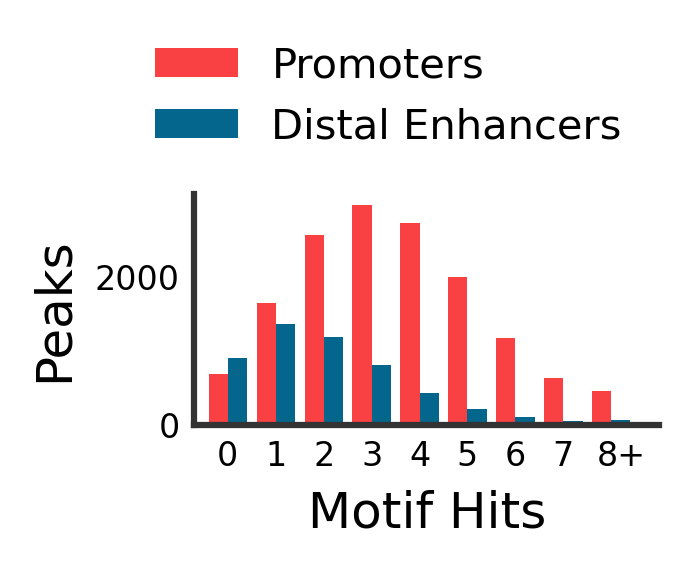

In [203]:
def plot_motif_complexity_across_ccres(motif_hit_counts, ccre_annots):
    annots_to_colors = {"All Peaks" : "gray", "PLS" : "#f94144", "dELS" : "#05668d"}

    annots_to_labels = {"PLS" : "Promoters",
                        "pELS" : "Proximal Enhancers",
                        "dELS" : "Distal Enhancers"}
    
    plt.figure(figsize=(2,1), dpi=300)
    
    for index, key in enumerate(["PLS", "dELS"]):
        motif_hit_counts_annot = motif_hit_counts[ccre_annots[key]]
        motif_hits_per_peak = motif_hit_counts_annot.sum(axis=1)

        hist_y, hist_x = np.histogram(motif_hits_per_peak, bins=range(np.max(motif_hits_per_peak)+2))

        stop_point = 8
        hist_y = list(hist_y[:stop_point]) + [np.sum(hist_y[stop_point:])]
        hist_x = list(hist_x[:stop_point]) + [stop_point]

        if key == "PLS":
            hist_x_adj = [num - 0.2 for num in hist_x]
        else:
            hist_x_adj = [num + 0.2 for num in hist_x]
        
        plt.bar(hist_x_adj, hist_y, width=0.4, color=annots_to_colors[key],
                label=annots_to_labels[key])

    plt.xlabel("Motif Hits", fontsize=12)
    plt.ylabel("Peaks", fontsize=12)

    xticklabels = []
    for i in hist_x:
        if i < stop_point:
            xticklabels.append(str(i))
        else:
            xticklabels.append(str(stop_point) + "+")

    x_tick_pos = list(hist_x)
    x_tick_pos[-1] += 0.2 
    plt.xticks(x_tick_pos, xticklabels)
    plt.xlim(-0.7, len(hist_x))
    plt.tick_params("both", length=0, labelsize=8)

    plt.legend(frameon=False, bbox_to_anchor=(0.5,1,0.5,0.8), fontsize=10)
        
    ax = plt.gca()
    ax.spines["left"].set_linewidth(1.5)
    ax.spines["bottom"].set_linewidth(1.5)
    ax.spines["left"].set_color("#333333")
    ax.spines["bottom"].set_color("#333333")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.show()


plot_motif_complexity_across_ccres(motif_hit_counts, ccre_annots)

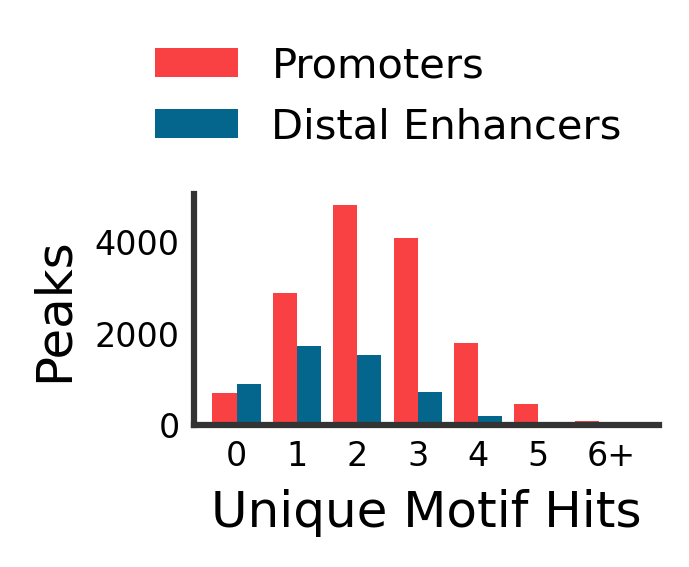

In [192]:
def plot_uniq_motif_complexity_across_ccres(motif_hit_counts, ccre_annots):
    annots_to_colors = {"All Peaks" : "gray", "PLS" : "#f94144", "dELS" : "#05668d"}

    annots_to_labels = {"PLS" : "Promoters",
                        "pELS" : "Proximal Enhancers",
                        "dELS" : "Distal Enhancers"}
    
    plt.figure(figsize=(2,1), dpi=300)
    
    for index, key in enumerate(["PLS", "dELS"]):
        motif_hit_counts_annot = motif_hit_counts[ccre_annots[key]]
        motif_hits_per_peak = (motif_hit_counts_annot > 0).sum(axis=-1).astype(np.int32)

        hist_y, hist_x = np.histogram(motif_hits_per_peak, bins=range(np.max(motif_hits_per_peak)+2))

        stop_point = 6
        hist_y = list(hist_y[:stop_point]) + [np.sum(hist_y[stop_point:])]
        hist_x = list(hist_x[:stop_point]) + [stop_point]

        if key == "PLS":
            hist_x_adj = [num - 0.2 for num in hist_x]
        else:
            hist_x_adj = [num + 0.2 for num in hist_x]
        
        plt.bar(hist_x_adj, hist_y, width=0.4, color=annots_to_colors[key],
                label=annots_to_labels[key])

    plt.xlabel("Unique Motif Hits", fontsize=12)
    plt.ylabel("Peaks", fontsize=12)

    xticklabels = []
    for i in hist_x:
        if i < stop_point:
            xticklabels.append(str(i))
        else:
            xticklabels.append(str(stop_point) + "+")

    x_tick_pos = list(hist_x)
    x_tick_pos[-1] += 0.2 
    plt.xticks(x_tick_pos, xticklabels)
    plt.xlim(-0.7, len(hist_x))
    plt.tick_params("both", length=0, labelsize=8)

    plt.legend(frameon=False, bbox_to_anchor=(0.5,1,0.5,0.8), fontsize=10)
        
    ax = plt.gca()
    ax.spines["left"].set_linewidth(1.5)
    ax.spines["bottom"].set_linewidth(1.5)
    ax.spines["left"].set_color("#333333")
    ax.spines["bottom"].set_color("#333333")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.show()


plot_uniq_motif_complexity_across_ccres(motif_hit_counts, ccre_annots)

In [152]:
def extract_seqs_at_motifs(motif_hits, coords, onehot_seqs, in_window, buffer_width = 0):
        
    ### DIFFERENT FROM FIG2: because the onehot_seqs here are in_window length   #############!!!!!!!!!!!!
    # Or maybe actually it's fine because of the "(in_window - onehot_seqs.shape[1]) // 2" ?
    
    def convert_motif_coords_to_seq_coords(coords, coord_indexes, motif_starts, motif_ends):
        real_starts = []
        real_ends = []
        for peak_index, start, end in zip(coord_indexes, motif_starts, motif_ends):
            peak_coords = coords[peak_index]
            peak_start, peak_end = peak_coords[1:3]
            real_start = start - peak_start - (in_window - onehot_seqs.shape[1]) // 2
            real_starts.append(real_start)
            real_ends.append(real_start + (end - start))
            #print(peak_start, peak_end, start, end, real_start)
        return np.array(real_starts), np.array(real_ends)
        
    coord_indexes = motif_hits["peak_index"]
    motif_starts = motif_hits["start"]
    motif_ends = motif_hits["end"]
    motif_rcs = motif_hits["strand"] == "-"
    
    motif_starts, motif_ends = convert_motif_coords_to_seq_coords(coords, coord_indexes,
                                                                  motif_starts, motif_ends)
    
    # For each seqlet, fetch the sequence
    motif_seqs = []
    for coord_index, motif_start, motif_end, rc in zip(coord_indexes, motif_starts, motif_ends, motif_rcs):
        motif_mid = (motif_start + motif_end) // 2
        if not (motif_mid - buffer_width < 0 or motif_mid + buffer_width > onehot_seqs.shape[1]):
            seq = onehot_seqs[coord_index, motif_start:motif_end]
            if rc:
                seq = seq[::-1, ::-1]
            motif_seqs.append(seq)

    motif_seqs = np.stack(motif_seqs)
    return motif_seqs


# this is also in 5_modisco/report_utils.py
def compute_per_position_ic(ppm, background=np.array([0.25] * 4), pseudocount=0.001):
    alphabet_len = len(background)
    #ppm = np.abs(ppm)
    ic = ((np.log((ppm+pseudocount)/(1 + pseudocount*alphabet_len))/np.log(2))
          *ppm - (np.log(background)*background/np.log(2))[None,:])
    return np.sum(ic,axis=1)

# frankensteined together from how the hit caller code trims
def trim_by_ic(ppm, seq, target_len=25):
    per_pos_ic = compute_per_position_ic(seq)
    
    best_i = -1
    best_sum = 0
    for i in range(ppm.shape[0] - target_len + 1):
        new_sum = np.sum(per_pos_ic[i : i + target_len])
        if new_sum > best_sum:
            best_sum = new_sum
            best_i = i

    return ppm[best_i:best_i + target_len]


#def get_ccre_bools_for_motif_hits(motif_hits, ccre_coords):
#    # for each motif hit, find out if in any ccre
    
sys.path.append("../5_modisco")
from report_utils import load_modisco_results
modisco_results = load_modisco_results(modisco_results_path)
    

def plot_affinity_across_ccres(modisco_results, onehot_seqs,
                               patterns_to_keep, motif_hits,
                               coords, ccre_annots,
                               in_window, out_window, slice_len,
                               prof_width=200):

    pattern_type = "pos_patterns"
    patterns = modisco_results[pattern_type]

    cwm_score_dict = dict()
    motif_annots_by_pattern = dict()
    for ax_row_i, pattern_i in enumerate(patterns_to_keep):
        pattern_name = "pattern_" + str(pattern_i)
        pattern = patterns[pattern_name]
        
        # need to trim here because the hit caller trimmed
        cwm_trimmed = trim_by_ic(pattern["contrib_scores"][:], pattern["sequence"][:])

        # do ax_row_i here because the motif hit caller only saw filtered subset of motifs
        motif_hits_subset = motif_hits[motif_hits["key"] == ax_row_i]
        
        annots_aubset = {ccre : annots[motif_hits["key"] == ax_row_i] for ccre, annots in ccre_annots.items()}
        motif_annots_by_pattern[pattern_name] = annots_aubset
        
        motif_seqs = extract_seqs_at_motifs(motif_hits_subset, coords,
                                            onehot_seqs, in_window, buffer_width=prof_width)
        
        seq_scores = np.array([score_seq_by_cwm(cwm_trimmed, seq) for seq in motif_seqs])
        cwm_score_list[pattern_name] = seq_scores
        
    
        for key in ["PLS", "dELS"]:
            seq_scores_subset = seq_scores[annots_aubset]

            plt.hist(seq_scores_subset, label = key)
            
            plt.tick_params("both", length=0)

            ax = plt.gca()
            ax.spines["left"].set_linewidth(1.5)
            ax.spines["bottom"].set_linewidth(1.5)
            ax.spines["left"].set_color("#333333")
            ax.spines["bottom"].set_color("#333333")
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)

        plt.show()
        
plot_affinity_across_ccres(modisco_results, onehot_seqs,
                           patterns_to_keep, motif_hits,
                           coords, motif_annots, 
                           in_window, out_window, slice_len)

ValueError: need at least one array to stack

In [134]:
motif_hits

,chrom,start,end,key,strand,peak_index,imp_total_score,imp_frac_score,agg_sim,mod_delta,mod_precision,mod_percentile,fann_perclasssum_perc,fann_perclassavg_perc
0,chr9,97238424,97238449,2,+,7870,0.152324,0.037479,0.078225,0.000116,0.966102,0.116505,0.143866,0.230362
1,chrX,152958845,152958870,1,+,22617,0.468231,0.104589,0.117022,0.000101,0.920000,0.122622,0.226216,0.399577
2,chr17,21284664,21284689,1,-,23352,0.883718,0.127130,0.120092,0.000096,0.920000,0.106765,0.200846,0.447146
3,chr7,101162978,101163003,1,-,17883,0.588780,0.147494,0.129180,0.000085,0.825000,0.073996,0.261099,0.948203
4,chr21,46458495,46458520,4,+,18744,0.289581,0.076067,0.134540,0.000086,0.966667,0.134638,0.135788,0.169160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75683,chr6,11093689,11093714,9,+,2546,0.858662,0.192694,0.683982,0.000177,1.000000,0.823413,0.976190,0.996032
75684,chr20,34303021,34303046,9,+,26123,1.058768,0.210060,0.684380,0.000177,1.000000,0.841270,0.980159,0.996032
75685,chr19,55476487,55476512,9,-,16134,0.869326,0.144612,0.688360,0.000179,1.000000,0.928571,0.988095,0.998016
75686,chr20,34303021,34303046,9,+,4114,0.915905,0.201014,0.691772,0.000178,1.000000,0.888889,0.990079,0.998016


In [148]:
from load_annotations_utils import get_ccre_bed, load_annotations, get_overlap_annots, format_annot_list

def get_annotations_for_motifs(coords, annotation_file, in_window, out_window):
    annots = load_annotations(annotation_file)

    # get set of chromosomes included in peak set
    chroms = sorted(list(set(coord[0] for coord in coords)))

    # make dict of chromosome --> sorted list of annotated regions + labels
    annots_by_chrom = {chrom : sorted([a[1:] for a in annots if a[0] == chrom]) for chrom in chroms}
    
    # adjust the starts and ends of peak coordinates so they only cover +/- 500 bp
    # (otherwise we'd probably get a lot of FP annotation overlaps)
    adjust_by = (in_window - out_window) // 2
    coords_adjust = [(c[0], c[1] + adjust_by, c[2] - adjust_by) for c in coords]
    
    # get list of annotations overlapping peak, for each peak (takes a few min)
    overlap_annots_raw = [get_overlap_annots((coord[1:],), annots_by_chrom[coord[0]])[0] for coord in coords_adjust]
    
    # process raw string annotations into list of unique hits
    overlap_annots = [sorted(list(set(format_annot_list(annot_list)))) for annot_list in overlap_annots_raw]
    
    # get set of unique annotation labels
    all_annot_labels = set([annot for annot_list in overlap_annots for annot in annot_list])
    
    # make dict of annotation label --> list of len(num_peaks), where each element is True if overlap
    overlap_annots_bools = {annot_label : np.array([annot_label in annot_list for annot_list in overlap_annots]) for annot_label in all_annot_labels}
    return overlap_annots_bools



motif_coords = np.array([motif_hits["chrom"].values, motif_hits["start"].values, motif_hits["end"].values]).T

motif_annots = get_annotations_for_motifs(motif_coords, get_ccre_bed("K562"),
                           in_window, out_window)